# Bayesian Decision Science 

Adapted from Ravin Kumar's PyData Global 2020 talk on Bayesian Decision Science ([Youtube](https://www.youtube.com/watch?v=WT7o8QRIiQI))([Github](https://github.com/canyon289/PyDataGlobal_2020)), updated with `pymc` v4.0 and some notes on learning the new syntax.

His original talk was done with pymc3, and since then `pymc3` was rebranded as `pymc` and then they hit version 4.0 recently, which introduced some big changes.

In [1]:
import matplotlib.pyplot as plt
from scipy import stats, optimize
import numpy as np
import pandas as pd
# np.set_printoptions(precision=2, floatmode="fixed")
import arviz as az

%config InlineBackend.figure_format='retina'

Note the new way of importing `pymc`:

In [2]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0


## Newsvendor problem with fixed demand

Next few cells follows Ravin's example of a newsvendor problem. First section he discusses a very simple example where demand is fixed, then you can simply write out the problem in code below:

In [3]:
newspaper_cost = 5
customer_price = 7

anishas_inventory = 42
demand = 40

profit = demand*customer_price - newspaper_cost*anishas_inventory
 
f"Anisha makes ${profit} in profit"

'Anisha makes $70 in profit'

The next point is that you can use `numpy` and turn this into a function:

In [4]:
def daily_profit(inventory, demand, newsvendor_cost=5, customer_price=7):
    """Calculates profit for a given day given inventory and demand"""
    return customer_price*np.min([inventory, demand]) - newsvendor_cost*inventory

In [5]:
f"Decision 1: profit ${daily_profit(42, 40)}, Decision 2 profit ${daily_profit(38, 40)}"

'Decision 1: profit $70, Decision 2 profit $76'

### Optimization with `scipy.optimize` 

So he then demonstrates that you *could* just plot a whole bunch of values of inventory and graphically inspect where profit is maximized, but we can do this by turning it into an optimization problem using `scipy.optimize`.

In [6]:
# Restating here so future slides won't have the print
def objective(inventory: int, demands: iter):
    """Takes an iterable of sales and returns the total profit"""
    # Make reward function negative to turn this into a minimization problem
    return -np.sum([daily_profit(inventory, d) for d in demands])

In [7]:
# Let scipy find minimie objective function (negative profit) if demands is set to 40
opt_stoch = optimize.minimize_scalar(objective, bounds=(0, np.inf), args=([40, 40]))
opt_stoch

     fun: -159.9999981773509
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 43
     nit: 38
 success: True
       x: 40.00000018226491

Great, so we have an optimal objective value of -160 (i.e. \$160 in profit) and it found the optimal inventory is 40. Makes sense - if demand is exactly 40 then you optimize profit when you buy and sell exactly that number of newspapers.

## What if demand is uncertain

But real life is a little more complicated, so what if we simulate random demand?

Here, we simulate that demand is drawn from a normal distribution: $\mathcal{N}(40,20)$

In [8]:
np.random.seed(seed=0)
random_seeds = [1,2,3,4,5]
demand = np.round(stats.norm(40, 20).rvs(15)) 
demand_seen, demand_unseen = demand[:5], demand[5:]

In [9]:
f"The first five days demand we have seen {demand_seen}"

'The first five days demand we have seen [75. 48. 60. 85. 77.]'

In [10]:
f"The UNSEEN next ten days of demand {demand_unseen}"

'The UNSEEN next ten days of demand [20. 59. 37. 38. 48. 43. 69. 55. 42. 49.]'

## Instability in the sample mean and std deviation

He then goes on to use examples of taking the sample mean (the mean of the 5 days of demand that was seen) and the critical fractile equation to calculate the optimal inventory strategy.

I included his next point here, which is that 5 samples (i.e. seeing only 5 days of demand) can have wide differences in sample mean and std deviation. Very nice plot.

In [11]:
simulations = 100
mean, std = [], []

for _ in range(simulations):
    true_mean,true_std = 40, 20
    values = stats.norm(40, 20).rvs(5)
    mean.append(values.mean())
    std.append(values.std())

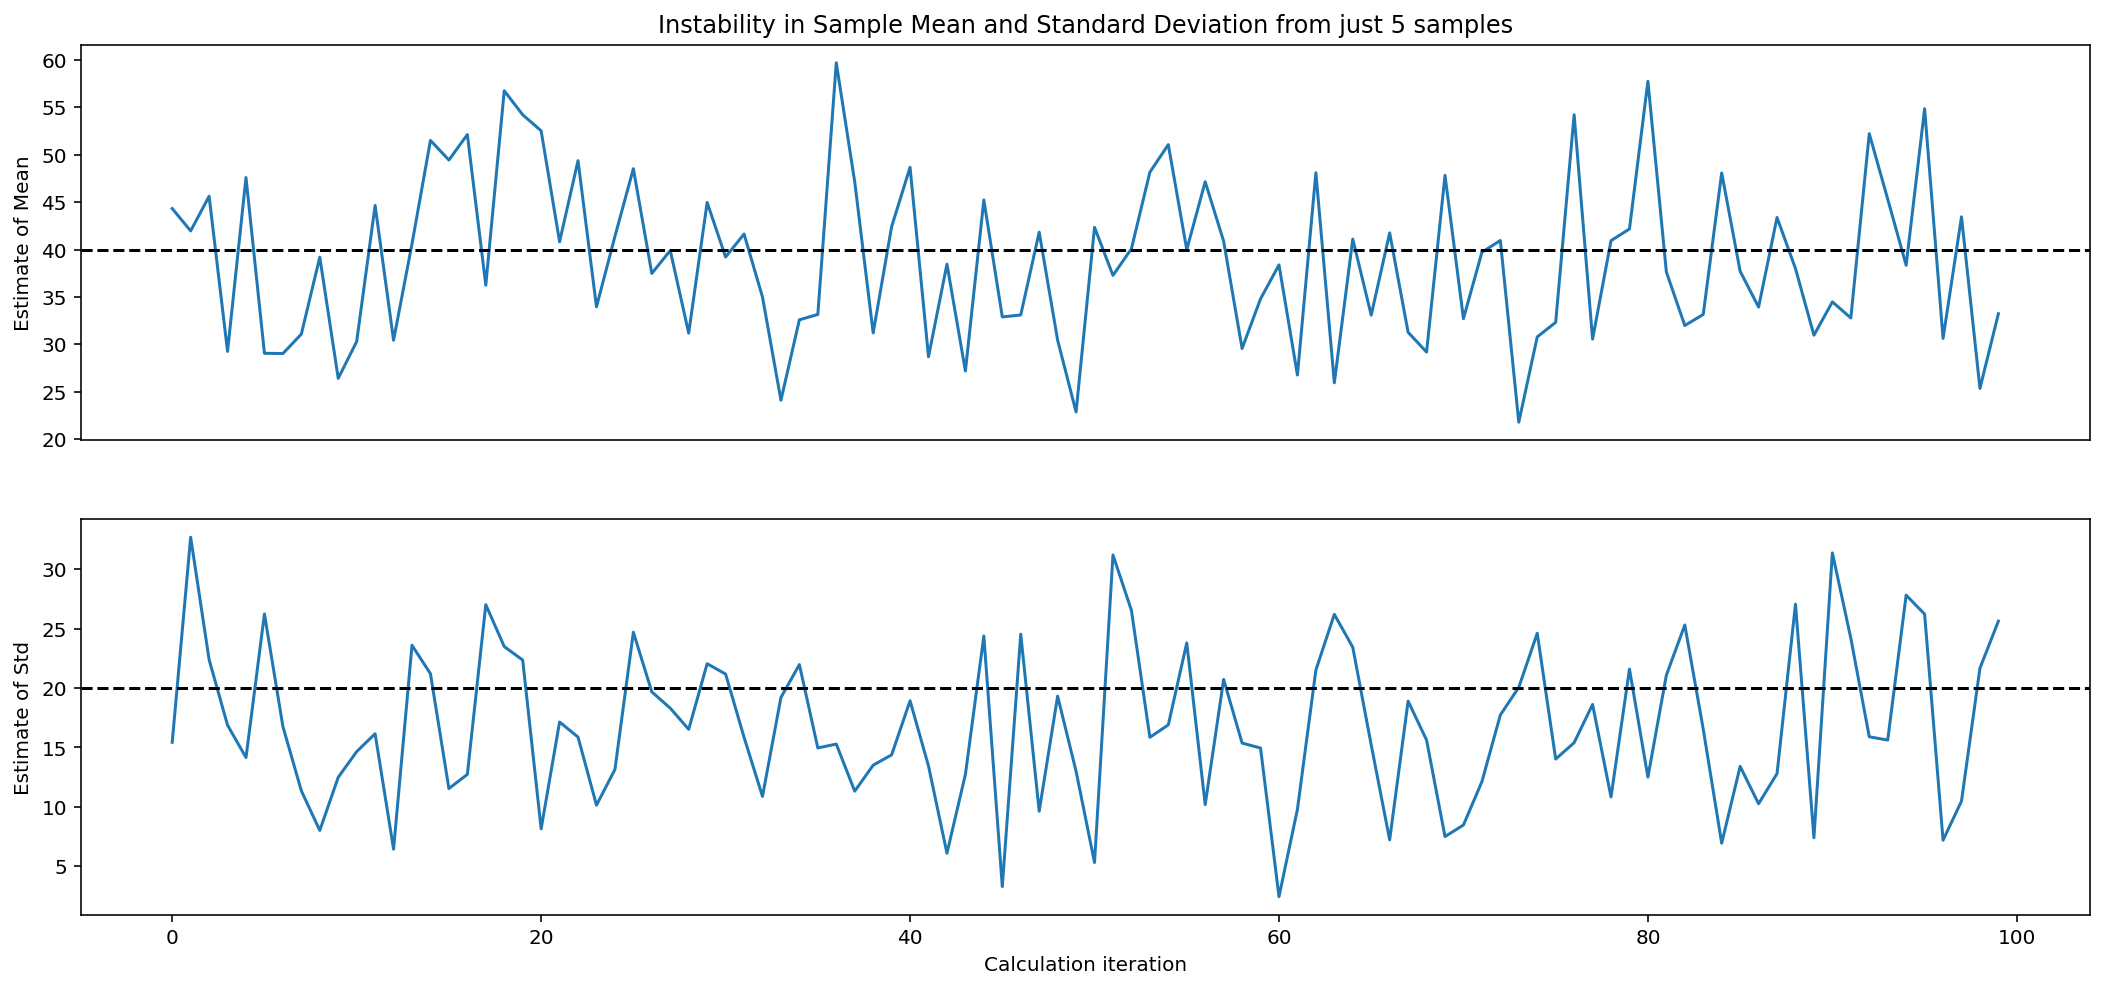

In [12]:
fig, ax = plt.subplots(2,1, figsize = (18, 8))

ax[0].plot(range(simulations), mean)
ax[0].set_xticks([])
ax[0].axhline(40, 0, 1, c="black", linestyle="--")
ax[0].set_ylabel("Estimate of Mean")

ax[1].plot(range(simulations), std)
ax[1].axhline(20, 0, 1, c="black", linestyle="--")
ax[1].set_xlabel("Calculation iteration") 
ax[1].set_ylabel("Estimate of Std")
 
ax[0].set_title("Instability in Sample Mean and Standard Deviation from just 5 samples");

## Enter Bayesian Modeling

Bayesian Modeling offers advantages because it handles this low sample size problem *natively*. He doesn't discuss how to choose informative priors and all that, but in this case he goes ahead and specifies the generative model below:

$$
\begin{aligned}
\sigma &\sim \text{HalfStudentT}(\sigma=10, \nu=20) & \text{Prior} \\
\mu &\sim \mathcal{N}(\mu=\bar{x}, \sigma=20) & \text{Prior} \\
\text{Demand} &\sim \text{TruncatedNormal}(\mu, \sigma) & \text{Likelihood}
\end{aligned}
$$

In [13]:
demand_mean, demand_std  = demand_seen.mean(), demand_seen.std()

### Specify the model in `pymc`

Below I make some slight modifications to follow with the `pymc` docs. The workflow starts with specifying the generative model as such:

In [14]:
newsvendor = pm.Model()

with newsvendor:
    
    # These are our priors that are set through "experience". Well get back to this
    sd = pm.HalfStudentT("standard_deviation_of_newspaper_demand", sigma=10, nu=20)
    mu = pm.Normal("mean_of_newspaper_demand", demand_seen.mean(), 20)
    demand = pm.TruncatedNormal("demand", mu=mu, sigma=sd, lower=0, observed = demand_seen)

So first the model is instantiated and then everything follows in the `with` call. The priors and the likelihood are specified using a series of distributions. Each distribution is given a name and the last item `demand` gets an additional call `observed` where you can add in the observed data.

### Sample to get posterior distributions

Next, we use `pm.sample`:

In [15]:
with newsvendor:
    idata = pm.sample(tune=5000, draws=10000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [standard_deviation_of_newspaper_demand, mean_of_newspaper_demand]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 17 seconds.


Here, idata is an `arviz.InferenceData` object, which is like a dataframe for storing the results of our sampling process. Here `pymc` automatically assigned the NUTS sampler for this problem, which is a nice 'batteries included' feature here. 

We can inspect this new object below:

In [16]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

And we can use `arviz` to call some helpful functions on this object. 

Here we can plot the posterior distribution of our parameters:

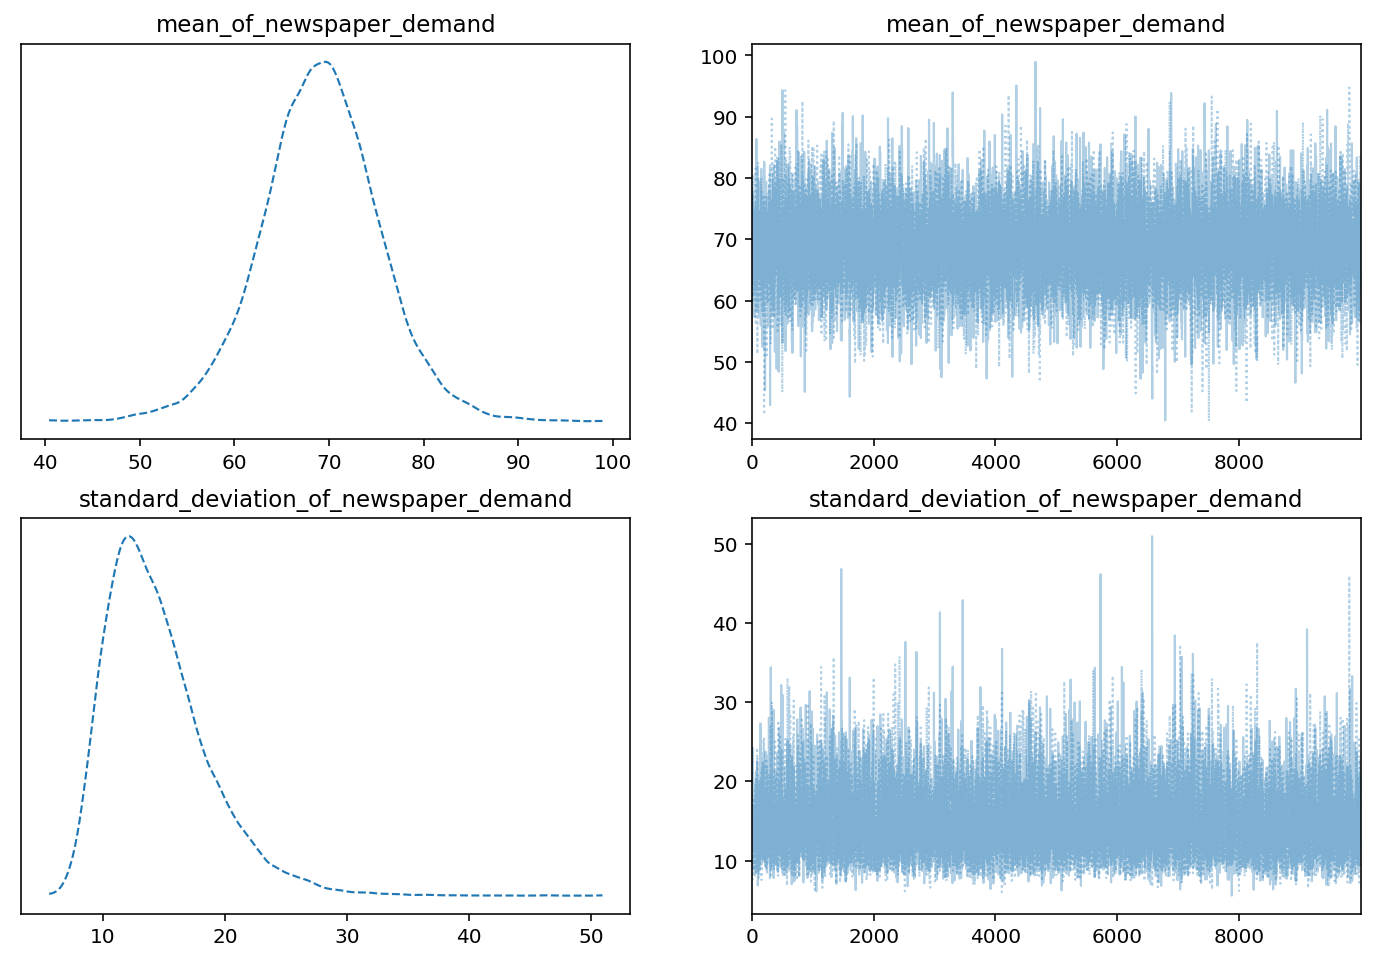

In [17]:
az.plot_trace(idata, combined=True, figsize=(12,8));

And if we were doing more inference:

`az.summary`: Output High level summary statistics

In [18]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_of_newspaper_demand,69.06,6.26,57.03,80.83,0.06,0.04,10463.73,9522.14,1.0
standard_deviation_of_newspaper_demand,14.51,4.24,7.92,22.46,0.04,0.03,11315.16,11185.45,1.0


### Sample posterior predictive

Next we can do a posterior predictive sample with `pm.sample_posterior_predictive()` and add the `extend_inferencedata` flag to add the posterior_predictive data as a new category with in our original `arviz.InferenceData` object.

In [19]:
with newsvendor:
#     posterior_predictive = pm.sample_posterior_predictive(idata, progressbar=True)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [20]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:       (chain: 2, draw: 10000, demand_dim_0: 5)
Coordinates:
  * chain         (chain) int64 0 1
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * demand_dim_0  (demand_dim_0) int64 0 1 2 3 4
Data variables:
    demand        (chain, draw, demand_dim_0) float64 30.64 72.65 ... 69.83
Attributes:
    created_at:                 2022-06-12T23:11:32.308825
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.0

`az.plot_posterior`: Pretty-plot the posterior using the style of Kruschke

array([<AxesSubplot:title={'center':'mean_of_newspaper_demand'}>,
       <AxesSubplot:title={'center':'standard_deviation_of_newspaper_demand'}>],
      dtype=object)

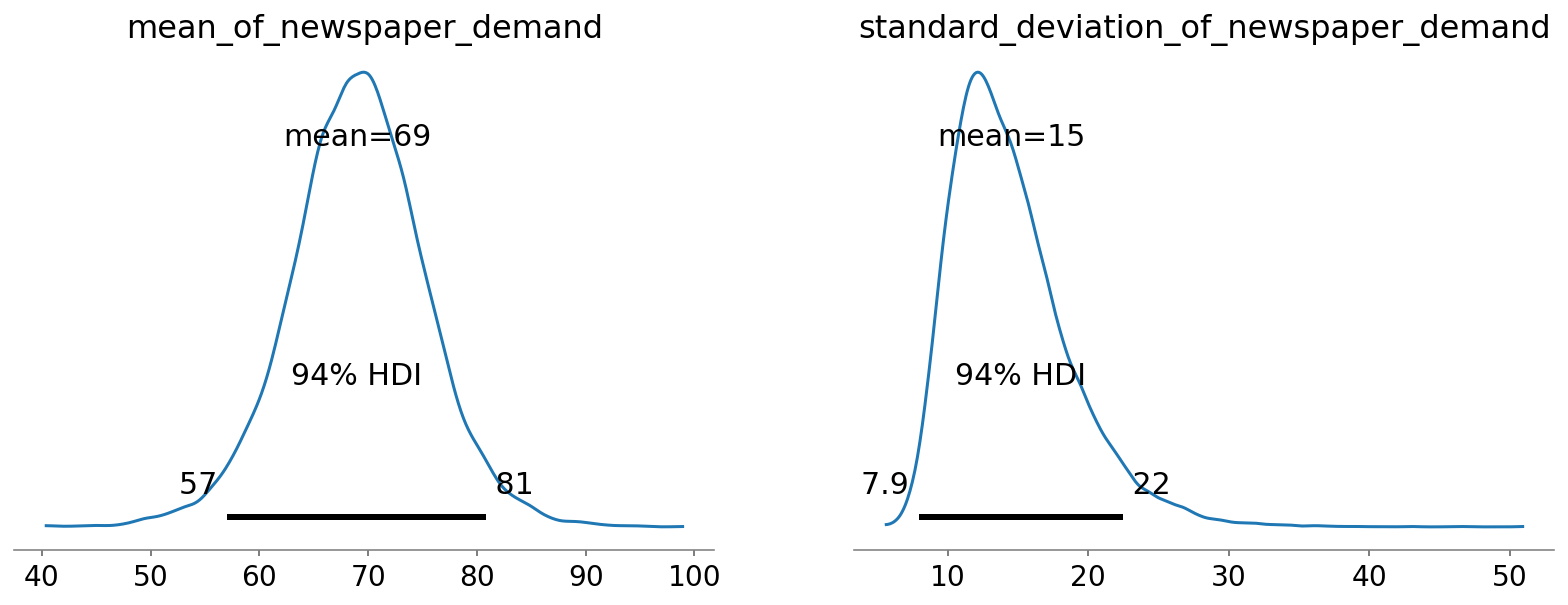

In [21]:
inf_data = az.convert_to_dataset(idata)
az.plot_posterior(inf_data)

Ravin's next point here is that we're using Bayesian Modeling to get all possible values of the demand we could see (given the 5 days of demand we've seen to date) and assign probabilities to each demand scenario.

He illustrates this below by showing a sample of 3 possible demand distributions:

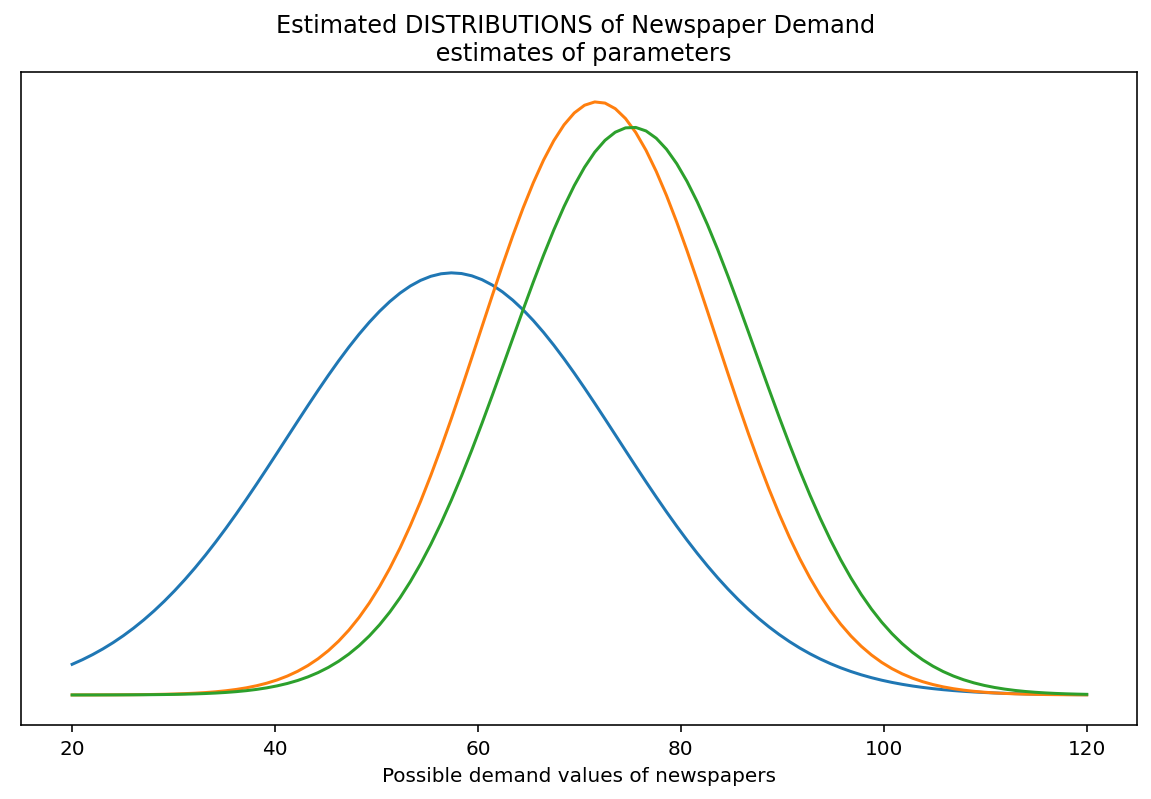

In [22]:
# Get random samples of possible distributions of demand and plot them. Used seed values 0, 10, 15

fig, ax = plt.subplots(figsize=(10, 6))

for seed in [0, 10, 23]:
    np.random.seed(seed)
    mean = np.random.choice(idata.posterior["mean_of_newspaper_demand"].values.flatten())
    std = np.random.choice(idata.posterior["standard_deviation_of_newspaper_demand"].values.flatten())

    x = np.linspace(20, 120, 100)
    y = stats.norm(mean, std).pdf(x)

    ax.plot(x,y)
    ax.set_yticks([]);

ax.set_title("Estimated DISTRIBUTIONS of Newspaper Demand \n estimates of parameters");
ax.set_xlabel("Possible demand values of newspapers");

Now, we can plot the posterior distribution of possible daily demand:

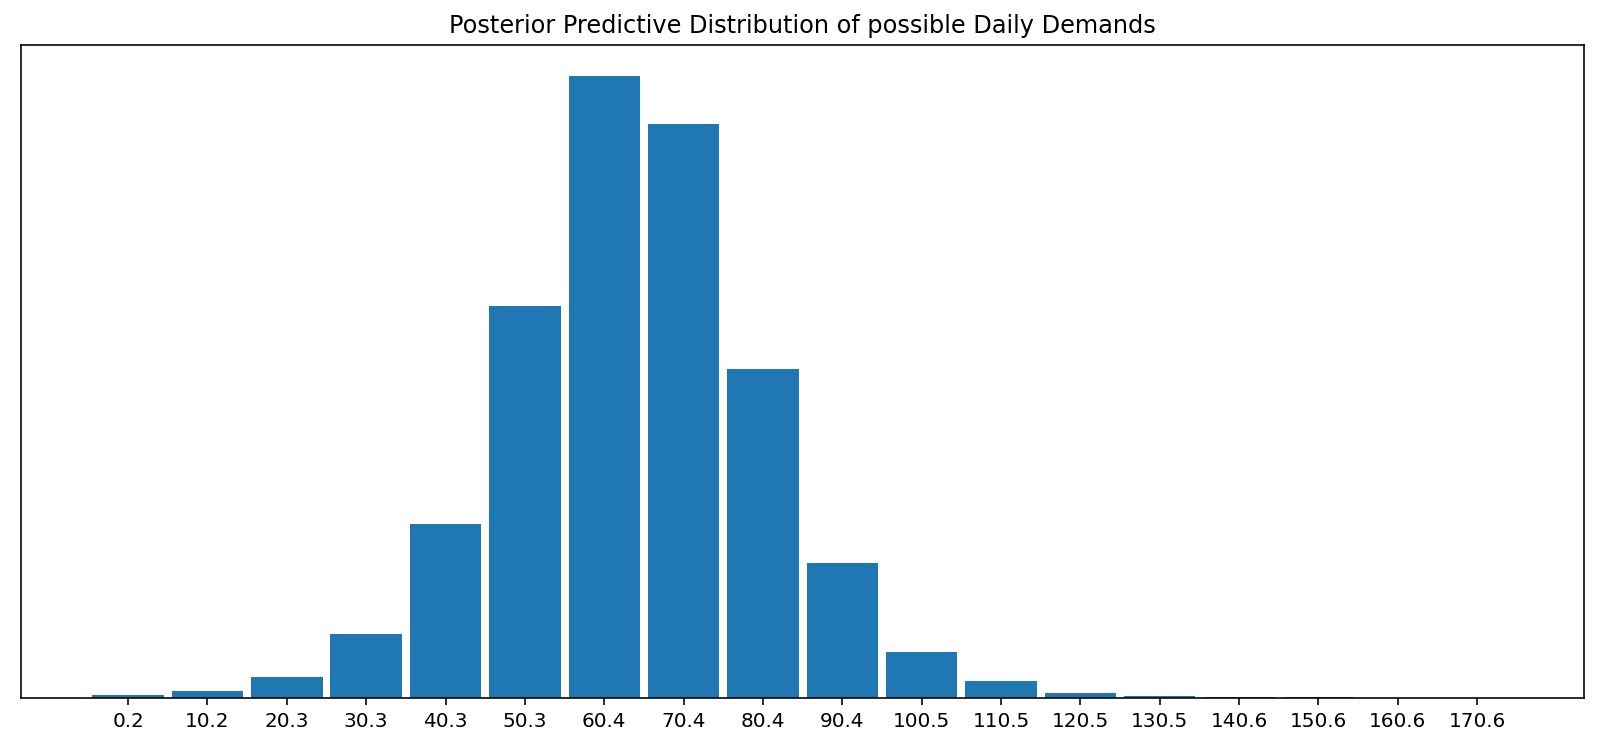

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))
bayesian_demand_estimates = idata.posterior_predictive["demand"].values.flatten()

az.plot_dist(bayesian_demand_estimates, kind="hist", ax=ax)
ax.set_title("Posterior Predictive Distribution of possible Daily Demands")
ax.set_yticks([]);

## Optimize over all possible demand scenarios

Now we can optimize over ALL of the possible demand scenarios

In [24]:
bayesian_demand_estimates = idata.posterior_predictive["demand"].values.flatten()
opt_stoch = optimize.minimize_scalar(objective, bounds=(0, np.inf), args=(bayesian_demand_estimates,))

In [25]:
bayes_opt = opt_stoch.x
f"Optimal inventory from Bayesian demand estimation and optimizer is {np.round(bayes_opt)} newspapers"

'Optimal inventory from Bayesian demand estimation and optimizer is 61.0 newspapers'

After calculating the optimal inventory strategy, we can then test this strategy on the 10 days of unseen demand and calculate the profit:

In [26]:
objective_func_value = objective(opt_stoch.x, demand_unseen)
f"Testing inventory choice over unseen days yields {objective_func_value} units. Lower is better"

'Testing inventory choice over unseen days yields -122.45445422518031 units. Lower is better'